# Oppsett av notebook

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
# This is copied from Howard's notebook: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data


#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

In [4]:
from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/')

In [5]:
import os
import torch

if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [6]:
import fastai.torch_core

device = None
if torch.cuda.is_available():
    device = fastai.torch_core.default_device('cuda')
elif torch.backends.mps.is_available():
    device = fastai.torch_core.default_device('mps')
else:
    device = fastai.torch_core.default_device('cpu')

In [7]:
print(device)

cuda:0


In [8]:
import warnings

# Ignore FutureWarning in fastai.data.transforms module
warnings.filterwarnings('ignore', category=FutureWarning, module='fastai.data.transforms')

# Datainspeksjon

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/chest-x-ray-flat/Data_Entry_2017.csv')

missing_values_count = df['Finding Labels'].isna().sum()

print(f"Antall manglende verdier i 'Finding labels': {missing_values_count}")

Antall manglende verdier i 'Finding labels': 0


In [10]:
import pandas as pd

labels_df = df['Finding Labels'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).to_frame('Label')

label_counts = labels_df['Label'].value_counts()

label_counts_df = label_counts.reset_index().rename(columns={'index': 'Label', 'Label': 'Count'})

label_counts_df

,Count,count
0,No Finding,60361
1,Infiltration,19894
2,Effusion,13317
3,Atelectasis,11559
4,Nodule,6331
5,Mass,5782
6,Pneumothorax,5302
7,Consolidation,4667
8,Pleural_Thickening,3385
9,Cardiomegaly,2776


# Databehandling

In [11]:
from fastai.vision.all import *

# Define the path to your dataset
path = Path('/kaggle/input/chest-x-ray-flat/images')

# Remove the No Finding labels from the dataset
df['Finding Labels'] = df['Finding Labels'].replace("No Finding", "")

#df = df.sample(frac=0.1, random_state=42)
batch_tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=8.0, max_zoom=1.2, max_lighting=0.3, max_warp=0.0)

# Create a DataBlock using label_func
dls = ImageDataLoaders.from_df(
    df,
    path,
    fn_col="Image Index",  # Column containing image file names
    label_delim='|',       # Specify the delimiter for multiple labels
    valid_pct=0.2,          # Split 20% as a validation set
    seed=42,
    item_tfms=[Resize(224)],          # Resize images to a consistent size
    y_block=MultiCategoryBlock(),  # Specify MultiCategoryBlock for multilabel classification
    batch_tfms=batch_tfms,
    batch_size=64
)

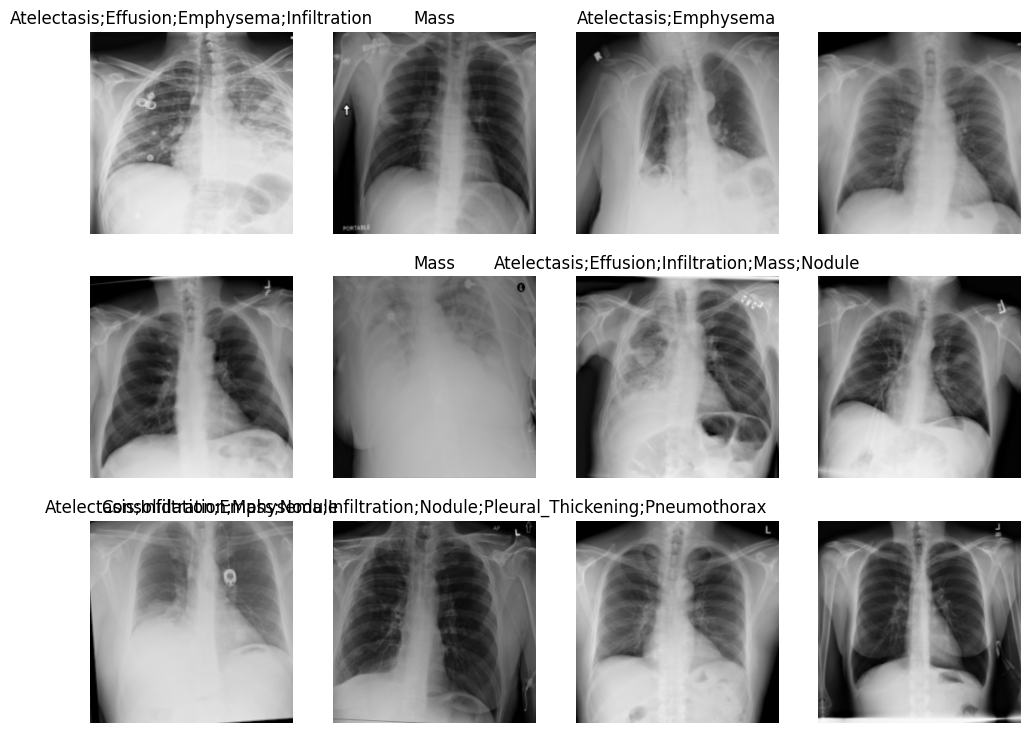

In [12]:
# Inspeksjon av data med labels
dls.show_batch(max_n=12)

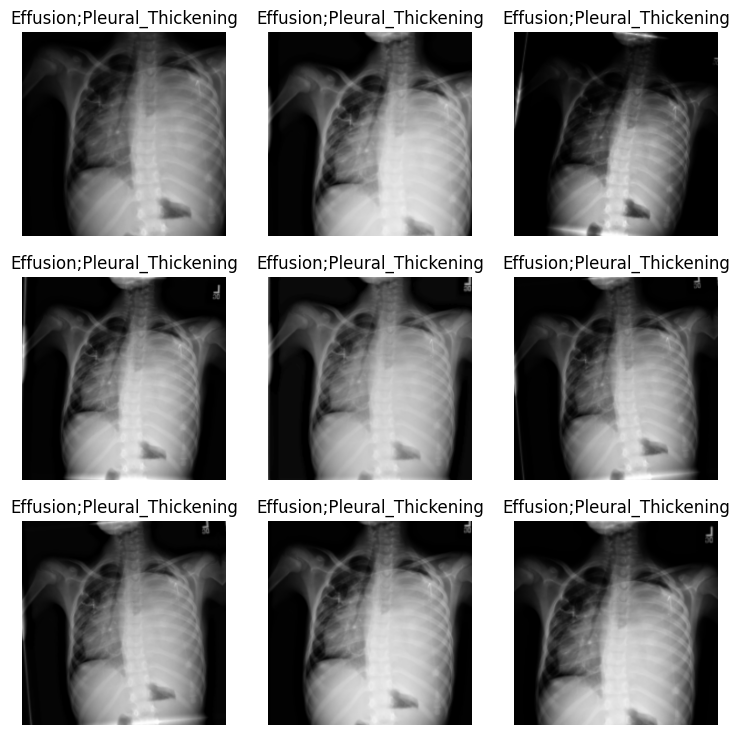

In [13]:
dls.show_batch(unique=True)

# Modelltrening

In [14]:
import timm
timm.list_models('convnext_base*')

['convnext_base']

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:10<00:00, 17.1MB/s]


epoch,train_loss,valid_loss,f1_score,time
0,0.175253,0.167966,0.000143,23:49


epoch,train_loss,valid_loss,f1_score,time
0,0.153569,0.151323,0.074090,24:11
1,0.154775,0.149951,0.068395,24:33
2,0.149540,0.149458,0.115734,25:27
3,0.155223,0.152356,0.082136,24:19
4,0.148940,0.148662,0.120217,24:25
5,0.147170,0.148836,0.133969,24:02
6,0.147669,0.150255,0.117726,23:42
7,0.141761,0.148105,0.189895,23:44
8,0.135530,0.147792,0.232271,23:43
9,0.135008,0.145912,0.199920,23:31


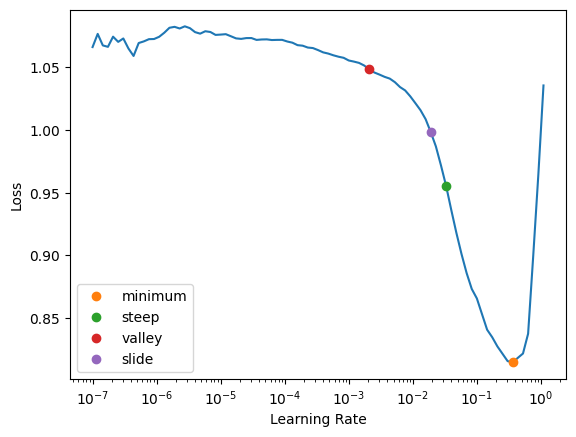

In [15]:
f1 = F1ScoreMulti()
learn = vision_learner(dls, resnet101, metrics=f1, model_dir='/kaggle/working/models')
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
learn.fine_tune(15, base_lr=lr.slide)

In [16]:
#learn.export('model.pkl')

# Resultater

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


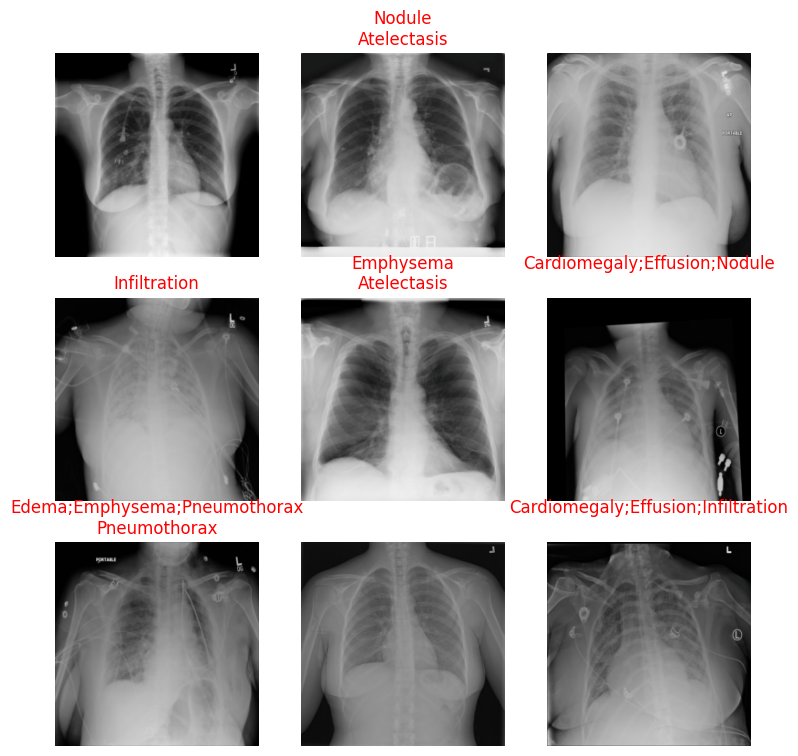

In [18]:
learn.show_results()

,target,predicted,probabilities,loss
0,Atelectasis;Hernia;Infiltration;Mass;Nodule;Pneumothorax,,"tensor([5.3821e-04, 5.0279e-06, 2.1654e-04, 1.4926e-06, 6.7778e-05, 9.0673e-04,\n 5.3573e-04, 4.5655e-08, 1.8451e-02, 5.0955e-05, 8.4290e-04, 2.9285e-04,\n 2.6776e-05, 4.7221e-01])",3.295546054840088
1,Cardiomegaly;Effusion;Emphysema,,"tensor([7.5596e-04, 1.9962e-07, 4.0818e-05, 4.0685e-07, 4.0407e-06, 1.8629e-04,\n 1.0907e-05, 2.9728e-08, 6.5445e-02, 1.0172e-04, 2.6136e-03, 3.5352e-05,\n 3.2853e-05, 4.1361e-07])",2.6075315475463867
2,Nodule,Effusion,"tensor([1.9520e-13, 1.2257e-25, 3.6712e-23, 0.0000e+00, 8.5011e-01, 2.4780e-35,\n 1.3522e-33, 0.0000e+00, 7.6912e-08, 6.9755e-21, 4.1734e-15, 6.6500e-29,\n 0.0000e+00, 2.6269e-19])",2.50056529045105
3,Edema;Infiltration;Mass;Nodule;Pneumonia,,"tensor([3.4933e-01, 4.2124e-05, 1.4245e-03, 6.5809e-03, 1.3064e-03, 3.6728e-05,\n 8.5560e-04, 8.0770e-07, 1.5167e-02, 1.4738e-03, 3.7531e-03, 6.1597e-04,\n 1.0461e-03, 1.8105e-05])",2.043863534927368
4,Atelectasis;Cardiomegaly;Effusion;Nodule,,"tensor([5.8638e-02, 1.8151e-05, 1.9329e-03, 3.5768e-06, 9.7804e-03, 1.3471e-06,\n 2.5437e-05, 1.6562e-09, 3.0886e-02, 6.5505e-05, 6.2952e-04, 2.3797e-03,\n 2.9771e-05, 4.4559e-05])",1.8419265747070312
5,Atelectasis;Consolidation;Effusion;Emphysema;Mass;Pneumothorax,Atelectasis,"tensor([8.0302e-01, 9.8049e-04, 1.8713e-02, 2.6397e-04, 2.1088e-01, 6.2225e-04,\n 1.3116e-03, 1.0194e-06, 1.6957e-01, 2.3165e-04, 3.4227e-04, 6.5093e-03,\n 4.7624e-03, 1.8911e-02])",1.8339163064956665
6,Mass;Pleural_Thickening,,"tensor([1.5295e-05, 2.0465e-07, 5.6600e-06, 1.2818e-07, 6.2850e-05, 4.6622e-07,\n 1.5853e-07, 4.8480e-11, 2.0162e-02, 1.0206e-06, 3.4909e-05, 8.3867e-06,\n 3.5938e-06, 5.3582e-06])",1.8217482566833496
7,Fibrosis;Hernia,,"tensor([7.5127e-03, 1.1085e-04, 9.5025e-04, 1.1159e-04, 2.0676e-02, 3.9430e-03,\n 8.3422e-04, 1.9016e-08, 1.4945e-02, 4.4581e-04, 2.4837e-03, 2.3396e-02,\n 8.3581e-05, 1.0867e-01])",1.7898093461990356
8,Atelectasis;Consolidation;Mass,,"tensor([9.2401e-04, 1.0753e-04, 4.7884e-04, 4.8009e-05, 8.1993e-05, 1.3889e-04,\n 1.1046e-03, 2.8663e-06, 1.9264e-01, 5.7523e-05, 8.6971e-03, 2.7009e-04,\n 7.9670e-04, 2.6444e-05])",1.7585391998291016
9,Mass;Pleural_Thickening;Pneumothorax,,"tensor([2.3598e-03, 8.2193e-05, 2.8598e-03, 1.3592e-03, 8.1593e-04, 5.6244e-03,\n 1.0118e-05, 1.9356e-07, 4.1314e-02, 7.1977e-04, 1.6858e-03, 1.1027e-04,\n 1.7042e-04, 2.9798e-04])",1.7517763376235962


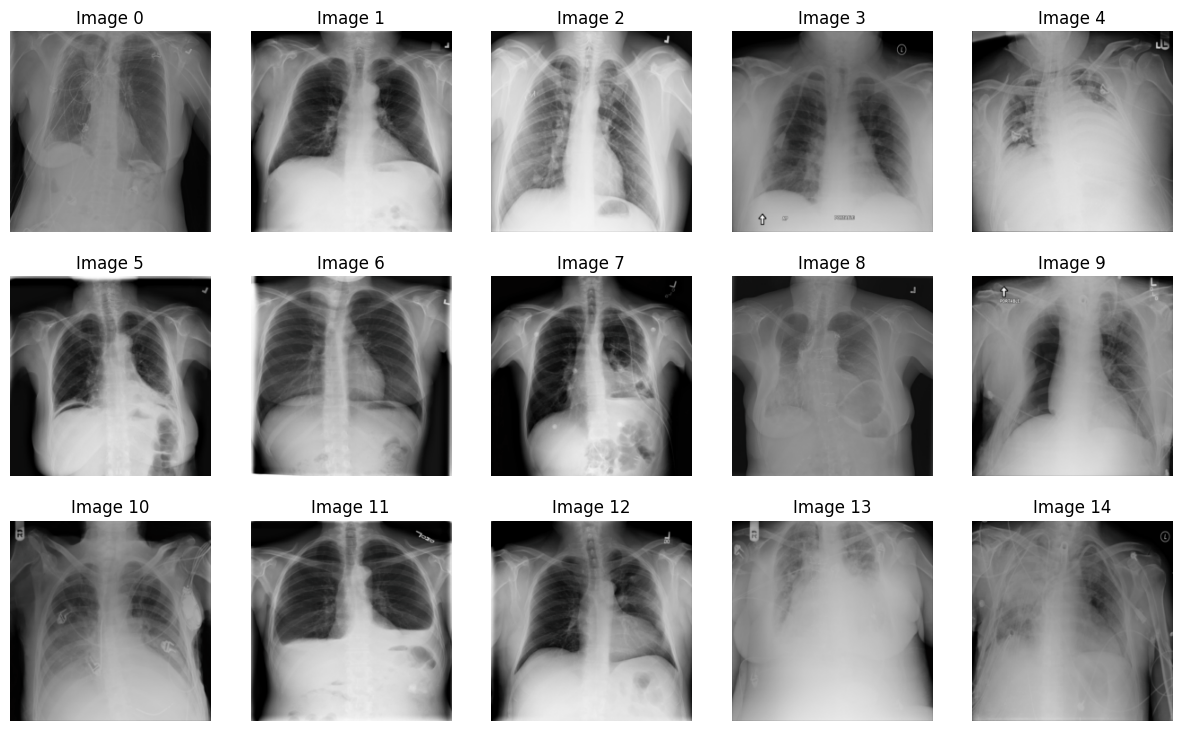

In [19]:
# Bildene modellen tolker dårligst
interp.plot_top_losses(15, nrows=3)

In [20]:
# Mest forvekslede diagnoser
interp.most_confused()

[('Cardiomegaly', 'Atelectasis', 12151), ('Atelectasis', 'Cardiomegaly', 4529)]

In [21]:
predictions, targets = learn.get_preds()

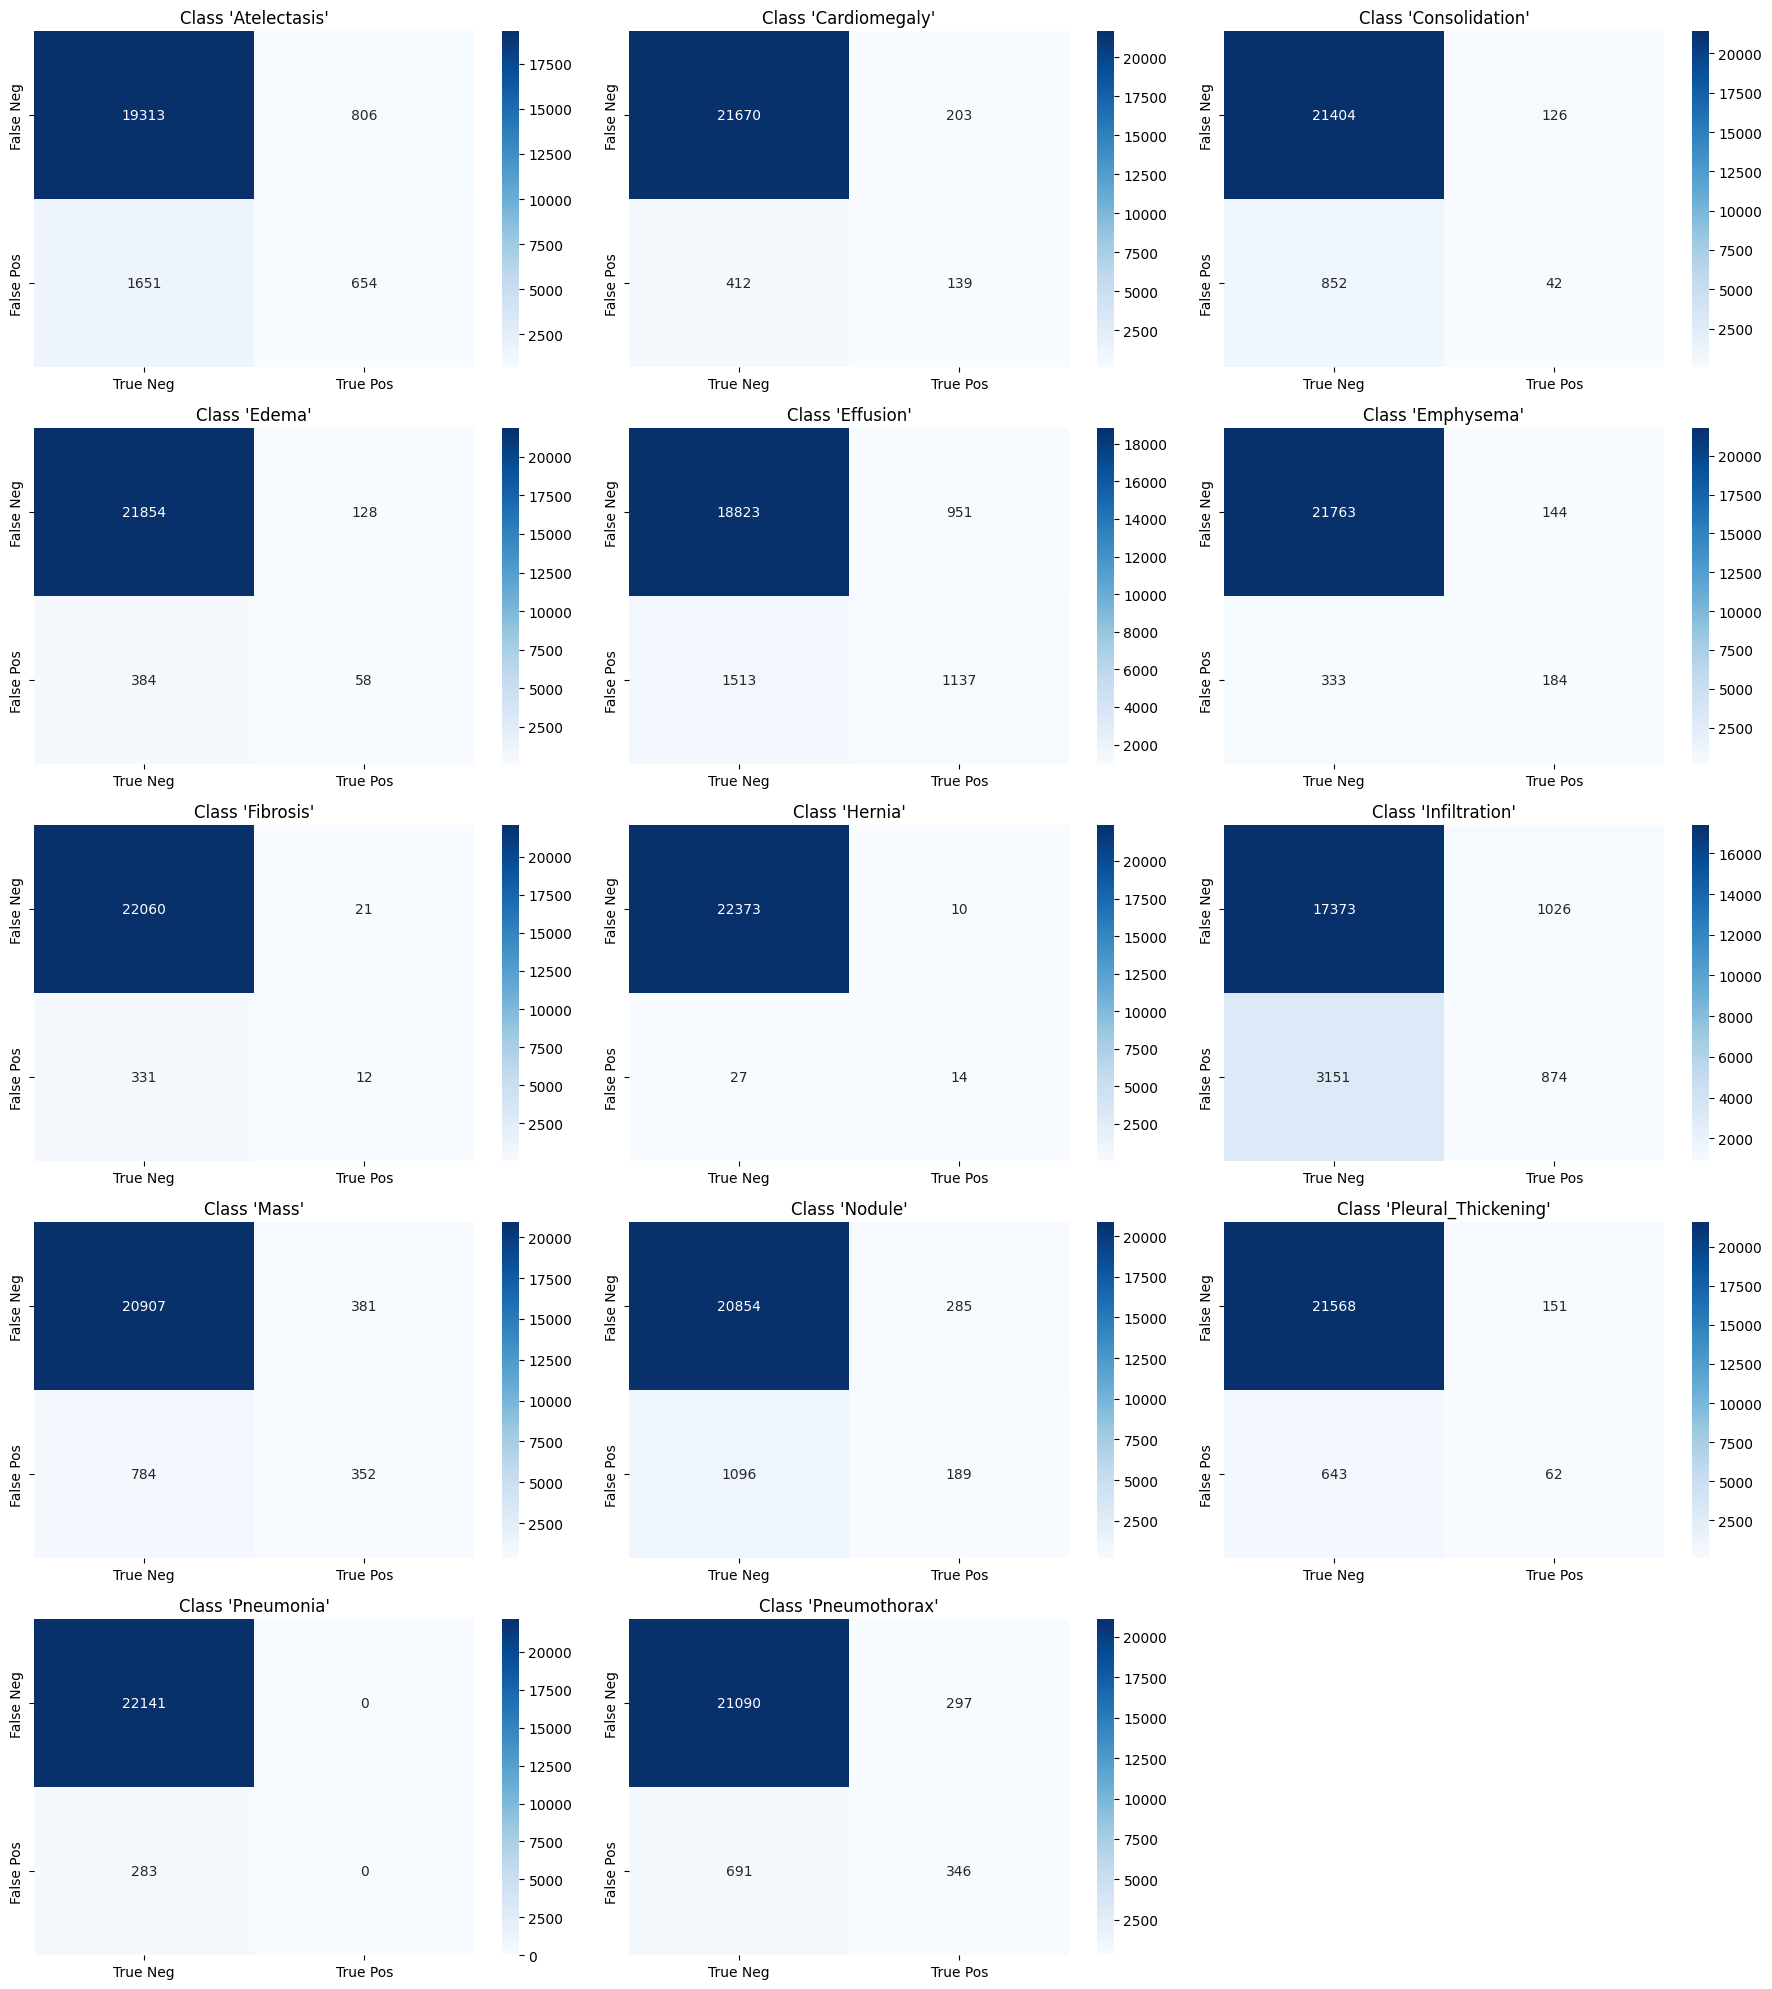

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

#[[TN, FP],
# [FN, TP]]

# Convert the predictions and labels to numpy arrays
preds_np = predictions.numpy()
labels_np = targets.numpy()

# Convert probability predictions to binary predictions (assuming a threshold of 0.5)
binary_preds = (preds_np > 0.5).astype(int)

# Get class names from DataLoaders
class_names = learn.dls.vocab

# Calculate multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(labels_np, binary_preds)

# Plot 5 rows of 3 confusion matrices side by side
fig, axes = plt.subplots(5, 3, figsize=(18, 20))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot the confusion matrices
for i, (matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['True Neg', 'True Pos'], yticklabels=['False Neg', 'False Pos'], ax=axes[i])
    axes[i].set_title(f"Class '{class_name}'")

# Remove any empty subplots
for i in range(len(confusion_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()